In [1]:
import os
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as tr
from collections import OrderedDict

In [2]:
torch.cuda.is_available()

True

In [3]:
data_dir = 'tomatoes'
print(os.listdir(data_dir))

['train', '.DS_Store', 'test']


In [4]:
classes = os.listdir(data_dir + "/train/Images")
print(classes[:10])

['riped', '.DS_Store', 'unriped']


In [5]:
dataset = ImageFolder(data_dir + '/train/Images', transform=tr.ToTensor())

In [6]:
img, label = dataset[0]
print(img.shape, label)
img,dataset.classes[label]

torch.Size([3, 640, 640]) 0


(tensor([[[0.3569, 0.3412, 0.2039,  ..., 0.8745, 0.8588, 0.8471],
          [0.3686, 0.3529, 0.2157,  ..., 0.8784, 0.8588, 0.8510],
          [0.3843, 0.3686, 0.2314,  ..., 0.8824, 0.8627, 0.8549],
          ...,
          [0.0667, 0.0706, 0.0863,  ..., 0.1843, 0.2000, 0.2078],
          [0.0353, 0.0471, 0.0824,  ..., 0.1843, 0.2000, 0.2078],
          [0.0235, 0.0392, 0.0784,  ..., 0.1843, 0.2000, 0.2039]],
 
         [[0.5255, 0.5098, 0.3647,  ..., 0.8745, 0.8667, 0.8549],
          [0.5373, 0.5216, 0.3765,  ..., 0.8784, 0.8667, 0.8588],
          [0.5529, 0.5373, 0.3922,  ..., 0.8824, 0.8667, 0.8588],
          ...,
          [0.2784, 0.2824, 0.2980,  ..., 0.3490, 0.3647, 0.3725],
          [0.2549, 0.2667, 0.2902,  ..., 0.3490, 0.3647, 0.3725],
          [0.2431, 0.2588, 0.2863,  ..., 0.3490, 0.3647, 0.3686]],
 
         [[0.3176, 0.2980, 0.1451,  ..., 0.5922, 0.5804, 0.5686],
          [0.3294, 0.3098, 0.1569,  ..., 0.5961, 0.5804, 0.5725],
          [0.3451, 0.3255, 0.1725,  ...,

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    

Label:  riped (0)


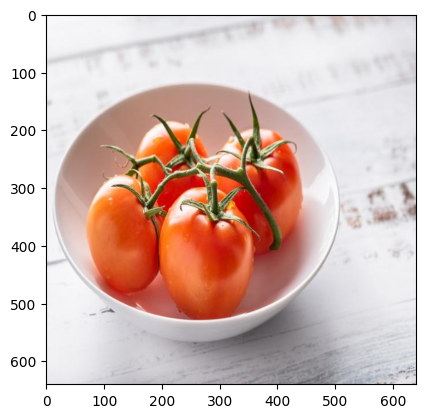

In [9]:
show_example(*dataset[2])

Label:  unriped (1)


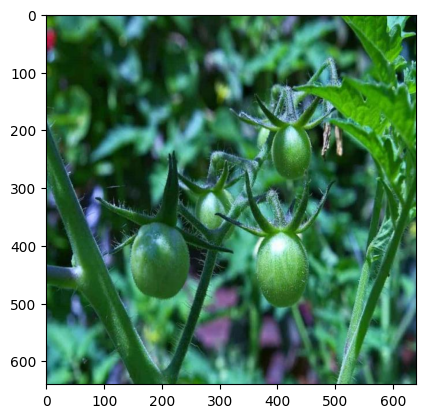

In [13]:
show_example(*dataset[120])

In [14]:
random_seed = 50
torch.manual_seed(random_seed);
len(dataset)

139

In [15]:
val_percent = 0.05 #we take 5% data for validation at first
val_size = int(val_percent*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(133, 6)

In [16]:
from torch.utils.data.dataloader import DataLoader

batch_size=32

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [18]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

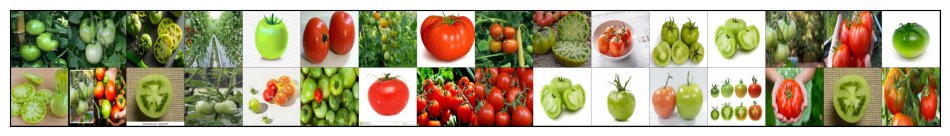

In [19]:
show_batch(train_dl)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class CNNNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda() 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
model = CNNNet()
model

CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=2, bias=True)
  )
)

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break



images.shape: torch.Size([32, 3, 640, 640])
out.shape: torch.Size([32, 2])
out[0]: tensor([-0.0453,  0.0291], grad_fn=<SelectBackward0>)


In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=2, bias=True)
  )
)

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
model = to_device(CNNNet(), device)

In [28]:
evaluate(model, val_dl)

{'val_loss': 0.6965513825416565, 'val_acc': 0.3333333432674408}

In [29]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [30]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6418, val_loss: 1.9511, val_acc: 0.2349
Epoch [1], train_loss: 0.3969, val_loss: 1.4863, val_acc: 0.5000
Epoch [2], train_loss: 0.2829, val_loss: 1.2385, val_acc: 0.5211
Epoch [3], train_loss: 0.2865, val_loss: 1.1032, val_acc: 0.5384
Epoch [4], train_loss: 0.2491, val_loss: 0.9511, val_acc: 0.6667
Epoch [5], train_loss: 0.2560, val_loss: 0.7632, val_acc: 0.7125
Epoch [6], train_loss: 0.3588, val_loss: 0.6099, val_acc: 0.8103
Epoch [7], train_loss: 0.2435, val_loss: 0.5139, val_acc: 0.8623
Epoch [8], train_loss: 0.2716, val_loss: 0.2577, val_acc: 0.9280
Epoch [9], train_loss: 0.2125, val_loss: 0.0751, val_acc: 0.9880


In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [32]:
test_dataset = ImageFolder(data_dir + '/test/Images', transform=tr.ToTensor())

Label: unriped , Predicted: unriped


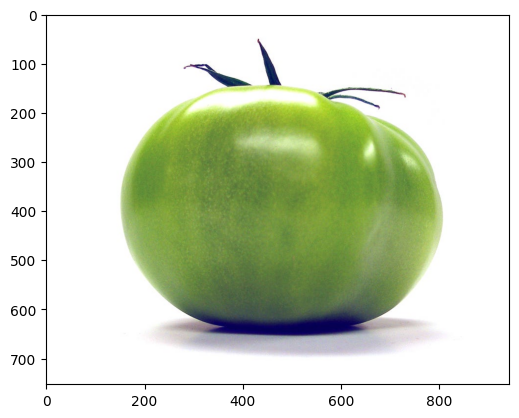

In [33]:
img, label = test_dataset[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: riped , Predicted: riped


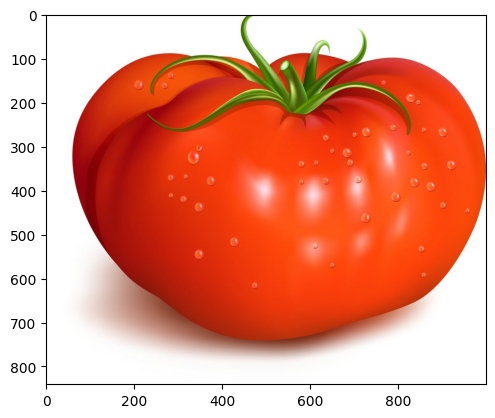

In [34]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))